# Adaption der Objektextraktion
Hallo! Wir wollen beliebige, selbstgewählte Objektkategorien auf Fotos (mit einfachem Hintergrund) erkennen. Sie brauchen also Fotos. Laden Sie diese auf Google-Drive hoch, oder nutzen Sie vorerst mal die [Giraffen-Puzzleteile](https://drive.google.com/drive/folders/1hXzFL_2Ot5PM3hvQCsgFhFeHV4wtG8E-?usp=drive_link). Die Daten sind auch im [dsci-Sharepoint-Ordner](https://ostch.sharepoint.com/:f:/r/teams/TS-FHS-IPM/Shared%20Documents/lehre%20und%20weiterbildung/21_Winf_MSc/10%20Module/DSCI/HS2024/Praktikum/Daten_Giraffe?csf=1&web=1&e=0OQ5db) abgelegt.

Ziel dieses Notebooks ist es, den Hintergrund der Bilder so gut zu "verstehen", dass das Skript `objekt_extraction.py` anschliessend aus allen Fotos die Objekte extrahieren kann. Auf einem Foto können mehrere Objekte abgebildet sein, wir extrahieren dann aber pro Objekt ein Bild. "verstehen" bedeutet gewisse Parameterwerte zu bestimmen, mit denen die Objektextraktion zuverlässig funktioniert.

Am Ende dieses Notebooks kennen wir diese Parameterwerte, und es wird das Skript `object_extraction.py` mit diesen Parameterwerten ausgeführt. Es extrahiert von allen Ihren Bildern die Ausschnitte (mit Objekten drin), welche wir für die Klassifizierung später brauchen.

Die Objektextraktion im Skript object_extraction.py kann je nach Beleuchtungsverhältnissen etc. unterschiedlich gut klappen und muss allenfalls adaptiert werden. Mit diesem Notebook können die einzelnen Verarbeitungsschritte dieses Skripts detailliert nachvollzogen werden. Die Parameter, deren Werte wir bestimmen müssen, heissen:

In [3]:
pr = 225,400 #PREPROCESSING_RESOLUTION, --preprocessing_resolution
tf = 0  #TOP_FRACTION, --top_fraction
bf = 0  #BOTTOM_FRACTION, --bottom_fraction
lf = 0  #LEFT_FRACTION, --left_fraction
rf = 0.3  #RIGHT_FRACTION, --right_fraction



sign = +1 # +1 for black background, -1 for white background
vth = 160    #VALUE_THRESHOLD, --value_threshold
es = 2     #EROSION_SIZE, --erosion_size
ds = 3     #DILATION_SIZE, --dilation_size
mpx = 200 #MINIMUM NUMBER OF PIXELS, --minimum_number_of_pixels
Bilddateiendung = 'jpg' #Dateiendung der Bilder, ohne "."

Die angegebenen Werte sind Standardwerte, die Sie anpassen sollen.

## Setup und Zugriff zu den Bilddaten

In [4]:
!ls /kaggle/usr/lib/object_extraction

ls: /kaggle/usr/lib/object_extraction: No such file or directory


In [5]:
!tail /kaggle/usr/lib/object_extraction/object_extraction.py

tail: /kaggle/usr/lib/object_extraction/object_extraction.py: No such file or directory


In [6]:
from object_extraction import *

In [7]:
import os
#if os.path.exists('/content/drive'):
#    from google.colab import drive
#    drive.mount('/content/drive')
#else:

!ls Daten|head

fork-big_01.jpg
fork-big_02.jpg
fork-big_03.jpg
fork-big_04.jpg
fork-big_05.jpg
fork-big_06.jpg
fork-big_07.jpg
fork-big_08.jpg
fork-big_09.jpg
fork-big_10.jpg


Wenn das geklappt hat, haben Sie Zugriff auf die Daten! In der nächsten Zelle muss einfach der Pfad richtig angepasst werden. Dann sind Sie gerüstet für den Rest des Notebooks. Kopieren Sie jenen Pfad als String in die folgende Variable:

In [8]:
from pathlib import Path #Path ist eien Klasse, welche den Umgang mit Dateipfaden erleichtert
pfad_zu_daten_string = 'Daten'
pfad_zu_daten = Path(pfad_zu_daten_string)

pfad_zu_object_extraction =  Path('object_extraction')

Als nächstes benötigen wir den Pfad zu `lcl_colab/1_object_extraction`. Er muss in sys.path zu finden sein. In der nächsten Zelle wird dies getestet:

Nun sollte die Datei `object_extraction.py` gefunden werden und das Modul object_extraction importiert werden können

In [9]:
from object_extraction import *

Laden wir ein Bild!

<Axes: >

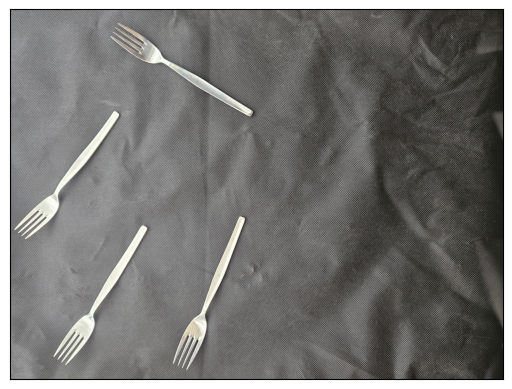

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

def show_image(im):
    imshow(im)
    ax = plt.gca()
    ax.set_xticks([]); ax.set_yticks([]);
    return ax

def choose_an_image():
    """
    Wähle eine Datei aus <pfad_zu_daten> und stelle es dar
    """
    Bilddatei_Liste = pd.Series(pfad_zu_daten.iterdir())
    fn = Bilddatei_Liste.sample(1).values[0]
    im = load_file(fn)
    return im

#im = choose_an_image()
im = load_file('Daten/fork-big_04.jpg')
show_image(im)

# Adaption der Parameter
Wir haben Zugriff auf die Bilddaten, nun möchten wir die Parameterwerte auswählen, welche die Objekte gut vom Hintergrund isolieren. Die Funktion `process_file` erledigt das.

Das Vorgehen dabei ist Folgendes:
1. Lade das Bild und reduziere die Auflösung: Parameter **`pr`** enthält ein Tupel mit der Anzahl Pixelzeilen und der Anzahl Pixelspalten. Dies dient hauptsächlich der Beschleunigung der weiteren Verarbeitung.
2. Schneide jeweils an den Rändern einen Prozentsatz der Zeilen bzw. Spalten ab: Der Prozentsatz der Zeilen ist durch **`fr`**, jener der Spalten durch **`fc`** gegeben.
3. Es wird ein Schwellwert auf den value-Wert (in der hsv-Farbdarstellung) angewendet, um den dunklen (`sign`=+1) oder hellen (`sign`=-1) Hintergrund zu erkennen. Dies ergibt eine Maske (binärer Array), welcher Vordergrundpixel identifiziert.
4. Es werden kleine Artefakte auf der Maske durch Erosion und Dilatation entfernt. Die Parameter `es` und `ds` geben die Grössen der Erosions- und Dilatationsmasken an.
5. Die Objekte werden ausgeschnitten, d.h. separate Objekte werden identifiziert, und um jedes Objekt wird eine enge rechteckige *Bounding Box* gesetzt.
6. Sollte der Ausschnitt weniger als **`mpx`** Pixel enthalten, wird er verworfen. Dies ist nötig, weil manchmal Reflexionen o.ä. zusätzliche kleine Ausschnitte erzeugen, welche aber nicht ein Objekt enthalten.
7. Ein neues Bild wird abgespeichert, welches nur noch das (ausgeschnittene) Bildelement enthält.


Wenn dies gelingt, sind die Bilder in einer geeigneten Form für Deep Learning.

Im Folgenden wird dieser Vorgang für ein (von Ihnen gewähltes) Bild durchgeführt. Passen Sie die Parameter so an, dass die Extraktion gut gelingt.  
Die Parameter sollten Sie hier anpassen:


### Schritt 0: Laden des Bildes

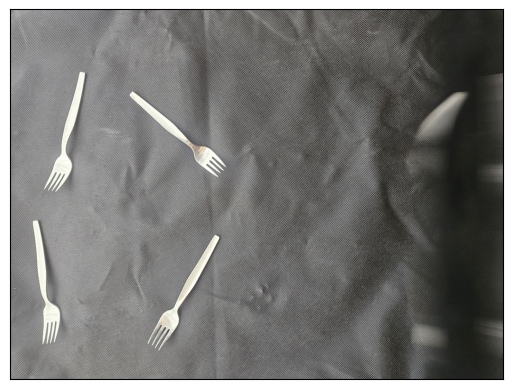

In [107]:
#im = choose_an_image()
im = load_file('Daten/fork-small-01.jpg')
show_image(im);

Das Bild hat aktuell die Auflösung

In [55]:
im.shape

(3000, 4000, 3)

### Schritt 1: Auflösungsreduktion

Die Bilder können zu hoch aufgelöst sein für unsere Anwendung, wodurch sich die Rechenzeit der folgenden Operationen vervielfacht. Die Vorverarbeitungsroutine `object_extraction.py` beginnt daher damit, mit der `--preprocessing_resolution` (oder `-pr`) das Bild zu verkleinern:

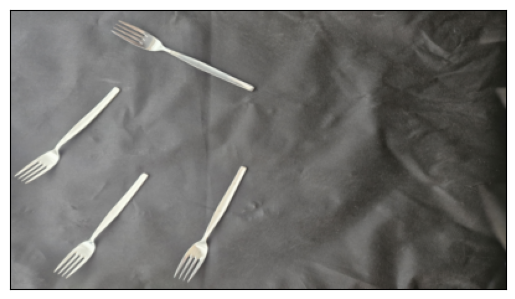

In [56]:
im_resized = (255*resize(im,pr)).astype('uint8')
show_image(im_resized);

Die Auflösung sollte nun Ihren Wünschen entsprechen (`NrRows`, `NrCols`, Anzahl Farbkanäle):

In [57]:
im_resized.shape

(225, 400, 3)

## Schritt 2: Ränder abschneiden
Als nächstes müssen ev. die Ränder des Bildes überdeckt werden. Damit können Artefakte beseitigt werden, z.B. wenn der schwarze Hintergrund nicht bis an den Rand des Bildes reicht. `fraction_of_rows_to_remove` und `fraction_of_cols_to_remove` geben an, wieviel abgeschnitten wird. Aufgefüllt werden die Pixel mit dem Wert `value_to_fill=0` (in allen Farbkanälen).

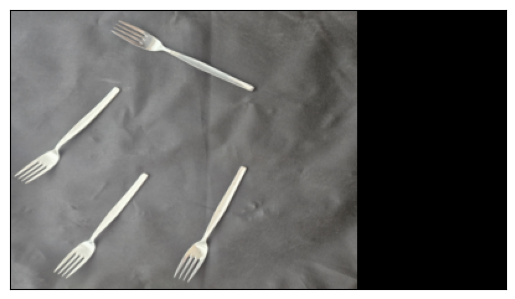

In [58]:
#im_filled = fill_borders(im_resized,value_to_fill=0,fraction_of_rows_to_remove=0.1,fraction_of_cols_to_remove=0)
im_filled = fill_borders_separate(im_resized, top_fraction=tf, bottom_fraction=bf, left_fraction=lf, right_fraction=rf)

show_image(im_filled);

**Aufgabe 1:** Finden Sie für Ihre Bilder passende Werte für `fraction_of_rows_to_remove` und `fraction_of_cols_to_remove`.

### Schritt 3: Hintergrundschwellwert bestimmen
Wählen Sie zunächst sign=+1 für Schwarzen Hintergrund oder sign=-1 für weissen Hintergrund.

Als nächstes soll ein Schwellwert im Farbraum das Objekt vom Hintergrund isolieren. Wir arbeiten im *hsv*-Raum: hue, saturation und value sind die drei Farbdimensionen, für welche jeweils ein Mindestwert (für sign=+1) bzw. Maximalwert (für sign=-1) für Vordergrundpixel festgelegt werden kann. Berechnet wird konkret: `mask = sign*im_hsv[:,:,2]>value_schwellwert*sign` (etc.).

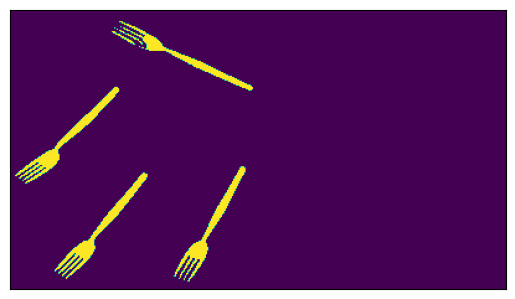

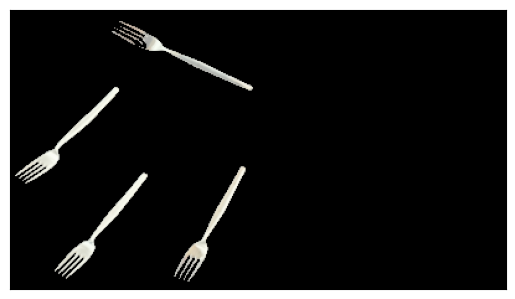

In [59]:
mask = generate_mask_with_hsv_threshold(im_filled,hue_threshold=None,saturation_threshold=None, value_threshold=vth)

plt.figure();show_image(mask);

masked_image = create_masked_image(im_filled,mask)
plt.figure();show_image(masked_image);

**Aufgabe 2:** Finden Sie Werte für `hue_schwellwert`, `saturation_schwellwert` und `value_schwellwert` so, dass die Maske möglichst gut zum Objektumriss passt. Bei der Wahl der Schwellwerte muss man aufpassen, dass sie nicht nur auf diesem einen Bild passen, sondern auch auf allen anderen!

In [80]:
help(generate_mask_with_hsv_threshold)

Help on function generate_mask_with_hsv_threshold in module object_extraction:

generate_mask_with_hsv_threshold(im, sign=None, hue_threshold=None, saturation_threshold=None, value_threshold=None)
    Erstelle eine Maske des Bildes (aktuell mit einem Schwellwert auf dem Value-Kanal des Bildes).



## Schritt 4: Erosion und Dilatationsfilgergrössen bestimmen

Wenn Hintergrundregionen übrigbleiben, dann ergibt dies zusätzliche Trainingsbilder, welche nicht einer Klasse zugeordnet sind- und es kostet auch viel Rechenzeit. Kleine, isolierte Maskenpixel möchten wir daher als nächstes durch Erosion entfernen.

**Aufgabe 3:** Finden Sie Werte für es und ds, welche möglichst keine vereinzelte Hintergrundpixel in der Maske übrig lassen:

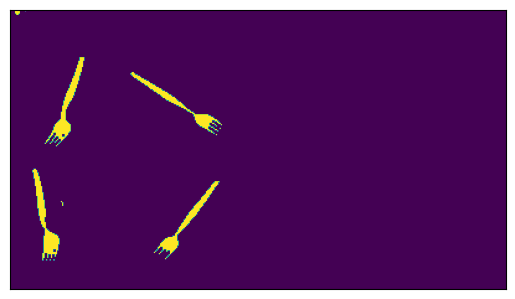

In [97]:
if es > 0 and ds > 0:
    morphed_mask = morphology_transform(mask,shape = square,erosion_size=es,dilation_size=ds)
else:
    morphed_mask = mask
show_image(morphed_mask);

Ev. haben Sie auch Glück, und Sie sehen oben nur eine einzige zusammenhängende gelbe Struktur? Dann können Sie die Werte so lassen, wie sie sind!

`create_mask` ist nun einfach eine Routine, welche die obigen Schritte der Maskenbildung zusammenfasst. Sie sollte das gleiche Bild `morphed_mask` wie oben erstellen:

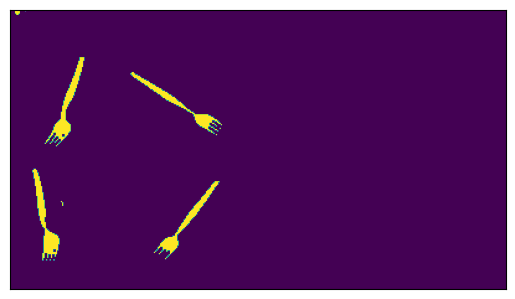

In [98]:
morphed_mask,im_filled  = create_mask(im_resized,top_fraction=tf, bottom_fraction=bf, left_fraction=lf, right_fraction=rf,hue_threshold=None,saturation_threshold=None,value_threshold=vth,erosion_size=es,dilation_size=ds)
show_image(morphed_mask);

Nun wird die Maske benutzt, um das Objekt (oder die Objekte) aus dem Bild auszuschneiden:

(225, 400, 3)

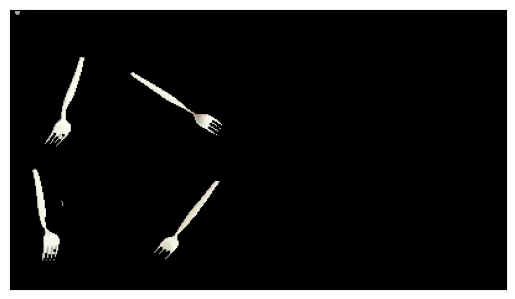

In [99]:
masked_image = create_masked_image(im_filled,morphed_mask)
show_image(masked_image);
masked_image.shape

Hier sollte ein Bild zu sehen sein, welches einen komplett schwarzen Hintergrund hat, und nur die relevanten Objekte zeigt. Als nächstes hätten wir gerne von jedem Objekt ein separates Bild, so dass wir darauf unseren Bildklassifikator trainieren können.

## Schritt 5: Objekte ausschneiden
Wir haben den Hintergrund eliminiert. Damit ist es nun leichter, die Objekte voneinander zu trennen. Eine Funktion von [scikit-image](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) tut dies:

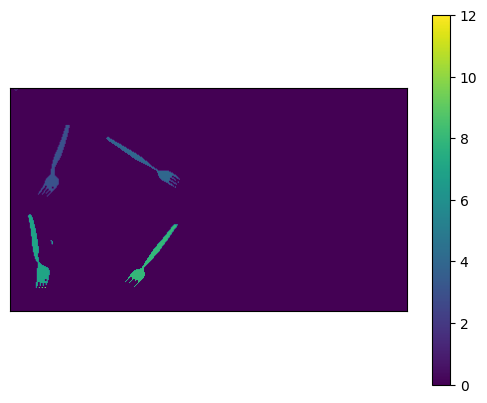

In [100]:
from skimage.measure import label
label_img = label(morphed_mask)
show_image(label_img)
plt.colorbar();

Falls das obige Bild wie eine Maske aussieht: Vermutlich liegt nur ein Bild vor- deren Pixel wird dann mit dem Wert "1" aufgefüllt. Wäre ein zweites Objekt vorhanden, würde dieses mit dem Wert "2" aufgefüllt und wäre in einer leicht anderen Farbe sichtbar. Aus diesem gelabelten Bild werden nun Teilbilder extrahiert, welche jeweils nur ein Objekt enthalten:

In [101]:
label_img.shape,masked_image.shape

((225, 400), (225, 400, 3))

In [102]:
regionlist,regions = extract_regions(label_img,masked_image,fraction_of_rows_to_remove=tf+bf)
len(regionlist)

12

Alle obigen Schritte sind in der Funktion image_preprocessing zusammengefasst:

In [109]:
regionlist,regions,mask,masked_image = image_preprocessing(im_resized,top_fraction=tf,bottom_fraction=bf,left_fraction=lf,right_fraction=rf,value_threshold=vth,erosion_size=es,dilation_size=ds)
print(f"Anzahl gefundene Bereiche: {len(regionlist)}")

Anzahl gefundene Bereiche: 12


In [110]:
label_img.shape,masked_image.shape,len(regions)

((225, 400), (225, 400, 3), 12)

<Axes: >

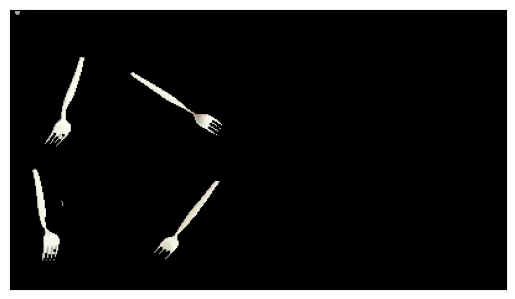

In [111]:
show_image(masked_image)

## Schritt 6: Kleine Objekte (Artefakte) ignorieren
Manchmal sind einige der gefundenen Regionen viel zu klein, um echte Objekte zu sein. Es gibt eine Option `--minimum-number-of-pixels` bzw. `-mpx`, welche Regionen unterdrückt, welche zu klein sind. Die Grösse der Regionen wird hier ausgegeben, um diesen Parameter gut einstellen zu können.

In [123]:
if len(regionlist)<20:
    for ireg,reg in enumerate(regions):
        print(f"Region {ireg}: {int(reg.area):>6}")
else:
    #for ireg,reg in enumerate(regions):
    #    print(f"{int(reg.area):<3} ",end='')

    plt.hist([reg.area for reg in regions],bins=np.logspace(1,6,100))
    plt.gca().set_xscale('log') #ev. sieht man damit etwas mehr
    plt.gca().set_yscale('log')

Region 0:     14
Region 1:      1
Region 2:    449
Region 3:    385
Region 4:      1
Region 5:      1
Region 6:    458
Region 7:    390
Region 8:      4
Region 9:      1
Region 10:      1
Region 11:      1


Schauen wir uns die extrahierten Regionen an - es sollten nicht zu viele sein.

**Aufgabe 4:** Bestimmen Sie einen geeigneten Wert von `mpx`, so dass nur relevante Regionen übrig bleiben. Tragen Sie den Wert in die Parameterliste ein.

Der `mpx`-Wert wird in der nächsten Zelle verwendet:

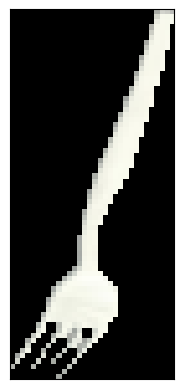

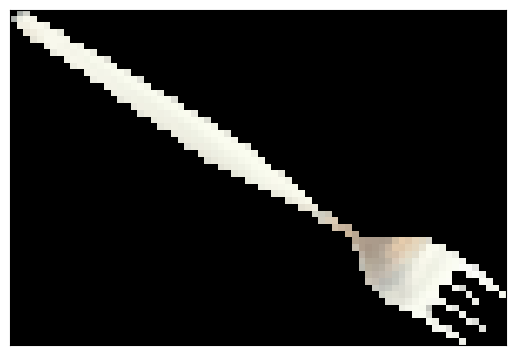

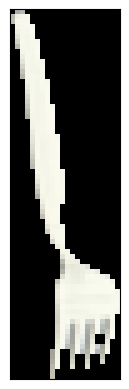

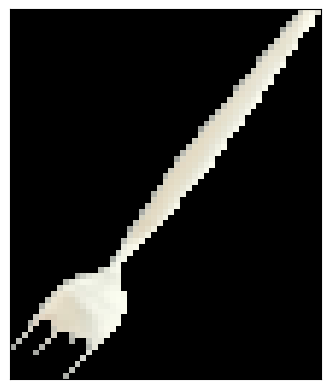

In [125]:
relevante_regionen =  [reg for reg in regions if reg.area >= 200]
if len(relevante_regionen)<20:
  for reg in relevante_regionen:
    plt.figure();
    plt.imshow(reg.image_intensity);
    plt.xticks([]);plt.yticks([]) # Wir brauchen keine x- und y-Achse
else:
  print(f"Das würde {len(relevante_regionen)} Graphiken erzeugen! Ich mache lieber nichts...")

Sehen Sie hier Ihre extrahierten Objekte, und keine (oder nur wenige) Artefakte?  
Ja?  
Wirklich?  
**Cool!**  
Dann können wir nun versuchen, alle weiteren Daten zu verarbeiten. Das kann  in der Kommandozeile wie folgt erreicht werden:

In [15]:
Ausgabepfad = Path('1_object_extraction_output')
Ausgabepfad.mkdir(mode=644,exist_ok=True)
Ausgabepfad

PosixPath('1_object_extraction_output')

In [16]:
imgfns = list(Path('Daten').glob('*.'+Bilddateiendung))
imgfns[:5]

[PosixPath('Daten/knife-big_05.jpg'),
 PosixPath('Daten/knife-big_11.jpg'),
 PosixPath('Daten/knife-big_10.jpg'),
 PosixPath('Daten/knife-big_04.jpg'),
 PosixPath('Daten/fork-small_09.jpg')]

In [19]:
yta = True #args.yes_to_all
outputpath = Ausgabepfad
outputpath_Ausschnitte = os.path.join(outputpath,'Ausschnitte')
ask_path_creation(outputpath_Ausschnitte,yes_to_all=yta)

top_fraction = float(tf)
bottom_fraction = float(bf)
left_fraction = float(lf)
right_fraction = float(rf)

preprocessing_resolution = [int(f) for f in pr]
print('preprocessing_resolution ',preprocessing_resolution )
erosion_size= intOrNone(1)
dilation_size= intOrNone(3)
hue_threshold = None#intOrNone(hth)
value_threshold = 150#None#intOrNone(vth)
saturation_threshold = None #intOrNone(sth)
write_summary_file = False
num_cores = 8 #int(args.num_cores)
minimum_number_of_pixels = 400

kwargs = {'top_fraction':tf,'bottom_fraction':bf,'left_fraction':lf,'right_fraction':rf,'hue_threshold':hue_threshold,'saturation_threshold':saturation_threshold,'value_threshold':vth,
        'erosion_size':erosion_size,'dilation_size':dilation_size,'min_num_pixels':minimum_number_of_pixels,'outputpath':outputpath_Ausschnitte,'preprocessing_resolution':preprocessing_resolution}

preprocessing_resolution  [225, 400]


In [21]:
NrFilesToProcess = None # None eingeben für alle
kwargs['num_cores']=8
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
main(imgfns[:NrFilesToProcess],kwargs)

Alternativ kann die Ausgabe der folgenden Zelle genutzt werden, um in der Kommandozeile das Skript [object_extraction.py](https://gitlab.ost.ch/beat.toedtli/learning-city-lab/-/blob/main/1_object_extraction/object_extraction.py?ref_type=heads)[im Verzeichnis [1_object_extraction](https://gitlab.ost.ch/beat.toedtli/learning-city-lab/-/tree/main/1_object_extraction?ref_type=heads) auszuführen.

In [283]:
from pathlib import Path
cmd = f"python3 '{pfad_zu_object_extraction}/object_extraction.py' \
-y -o '{Ausgabepfad}' -pr {pr[0]},{pr[1]} -tf {tf} -bf {bf} -lf {lf} -rf {rf} -es {es} -ds {ds} \
-vth {vth} -mpx {mpx} '{pfad_zu_daten_string}/*.jpg'"
print("Der Kommandozeilenbefehl lautet:\n",cmd)


Der Kommandozeilenbefehl lautet:
 python3 'object_extraction/object_extraction.py' -y -o '1_object_extraction_output' -pr 225,400 -tf 0 -bf 0 -lf 0 -rf 0.3 -es 2 -ds 3 -vth 160 -mpx 200 'Daten/*.jpg'


In [284]:
#Die Ausschnitte sind nun hier:
print(Ausgabepfad/'Ausschnitte')
# hier einige Beispiele:
!ls {'"'+str(Ausgabepfad/'Ausschnitte')+'"'}|head -n 5

1_object_extraction_output/Ausschnitte
fork-big_01.jpg_all.jpg
fork-big_02.jpg_all.jpg
fork-big_03.jpg_all.jpg
fork-big_04.jpg_all.jpg
fork-big_05.jpg_all.jpg


Wir können uns die Ausschnitte anschauen:

In [286]:
fn = Ausgabepfad/'Ausschnitte'/'rot-17_0_14.jpg'
if fn.exists():
    im = plt.imread(fn)
    show_image(im);

Bevor wir die Bilder herunterladen, wollen wir sie in Unterordner pro Klasse anordnen. 

# Bilden von Unterordner pro Klasse
Keras, unsere Deep Learning Bibliothek, hat eine einfache Routine, um Kategorisierte Bilder zu laden: Dazu müssen alle Bilder einer Klasse in einem Unterordner liegen, welcher als Namen die Klassenbezeichnung trägt. Diese Zuordnung kann natürlich von Hand vorgenommen werden. Im Fall des Giraffendatensatzes ist das Klassenlabel aber bereits im Dateinamen der Bilder codiert.

Um den Klassennamen 'rot' aus dem Dateinamen 'rot-17_0_10.jpg' zu extrahieren, sind reguläre Ausdrücke sehr nützlich. Reguläre Ausdrücke sind ziemlich kryptisch, aber mächtig und (nach etwas Übung) durchaus handlich.  
Wir importieren zunächst die Standard-[Python-Bibliothek](https://docs.python.org/3/library/re.html), welche reguläre Ausdrücke implementiert:

#### Reguläre Ausdrücke

In [12]:
import re
help(re.sub) #oder re.sub?

Help on function sub in module re:

sub(pattern, repl, string, count=0, flags=0)
    Return the string obtained by replacing the leftmost
    non-overlapping occurrences of the pattern in string by the
    replacement repl.  repl can be either a string or a callable;
    if a string, backslash escapes in it are processed.  If it is
    a callable, it's passed the Match object and must return
    a replacement string to be used.



In [32]:
re.sub('^([^-]*)-.*$','\\1','rot-17_0_10.jpg')

'rot'

Der reguläre Ausdruck `^([^-]*)-.*$` hat's durchaus in sich, ist aber verständlicher, wenn man folgendes weiss:  
- `^` bezeichnet den Beginn einer Zeichenkette
- `$` bezeichnet das Ende einer Zeichenkette
- `.` bezeichnet ein beliebiges Zeichen
- `*` meint "Null-mal, einmal oder beliebig oft". Gemeint ist hier das Zeichen davor ("."), als "kein oder beliebig viele beliebige Zeichen".
- `( )` Die Klammern gehören zusammen und bilden eine Gruppe: alle Zeichen dazwischen werden in einer Variablen abgespeichert, welche "\1" heisst. Dies sind die einzigen Zeichen, welche nach der Substitution die verbleibende Zeichenkette ausmachen: Im zweiten Argument von `re.sub` steht, womit ein "gematchtes Muster" (engl. matched pattern) im String ersetzt wird.
- In eckigen Klammern, `[]`, können Zeichen aufgezählt werden, die auftauchen dürfen. Innerhalb von eckigen Klammern bedeutet `^` *nicht* den Beginn des Strings, sondern eine Negation. Der Ausdruck `[^-]` bezeichnet daher ein beliebiges Zeichen, welches aber nicht das Minuszeichen sein darf.

Insgesamt sagt der Ausdruck `'^([^-]*)-.*$'` also so etwas wie:  
*Eine Zeichenkette matcht, wenn sie mit einer beliebigen Folge von Zeichen beginnt, welche nicht das Zeichen "-" ist, gefolgt von einem Minuszeichen. Diese Zeichen vor dem Minus bilden die Gruppe 1. Nach dieser Gruppe muss also ein "-" folgen, und danach dürfen noch beliebig viele beliebige Zeichen folgen bis zum Ende der Zeichenkette. Ersetze diese ganze Zeichenkette (von Anfang bis Ende) mit der Gruppe.*

In einfacherer Sprache ausgedrückt wird die Zeichenkette vor dem Minuszeichen extrahiert- sie enthält ja den Klassennamen.

#### Pandas DataFrames
Pandas DataFrames sind sehr nützliche tabellenartige Strukturen. Sie eignen sich v.a. für die Datenanalyse und Visualisierung von strukturierten Daten. Im Folgenden werden diese genutzt, um das Klassenlabel zu bestimmen, welches für die Erstellung der Baumstruktur nützlich ist.

In [41]:
volle_Dateinamen = [full_file_name for full_file_name in (Ausgabepfad/'Ausschnitte').glob('*.jpg')]
Basisnamen =  [full_file_name for full_file_name in (Ausgabepfad/'Ausschnitte').glob('*.jpg')]

#Basisnamen = [re.sub(r'^([^-]*-\d+).*$','\\1',bn.name) for bn in volle_Dateinamen] #Wende den regulären Ausdruck an
Klassenlabel = [re.sub(r'^([^-]*)-.*$','\\1',bn.name) for bn in Basisnamen] #Wende den regulären Ausdruck an
#Einfach nur, weil's cool ist: Pandas DataFrames! Hier eröffnet sich eine ganze Welt von Möglichkeiten
df = pd.DataFrame({'Dateiname':volle_Dateinamen,'Basisname':Basisnamen,'Klassenlabel':Klassenlabel})
df

,Dateiname,Basisname,Klassenlabel
0,1_object_extraction_output/Ausschnitte/knife-b...,1_object_extraction_output/Ausschnitte/knife-b...,knife
1,1_object_extraction_output/Ausschnitte/fork-bi...,1_object_extraction_output/Ausschnitte/fork-bi...,fork
2,1_object_extraction_output/Ausschnitte/knife-b...,1_object_extraction_output/Ausschnitte/knife-b...,knife
3,1_object_extraction_output/Ausschnitte/fork-bi...,1_object_extraction_output/Ausschnitte/fork-bi...,fork
4,1_object_extraction_output/Ausschnitte/fork-bi...,1_object_extraction_output/Ausschnitte/fork-bi...,fork
...,...,...,...
170,1_object_extraction_output/Ausschnitte/spoon-b...,1_object_extraction_output/Ausschnitte/spoon-b...,spoon
171,1_object_extraction_output/Ausschnitte/spoon-b...,1_object_extraction_output/Ausschnitte/spoon-b...,spoon
172,1_object_extraction_output/Ausschnitte/fork-bi...,1_object_extraction_output/Ausschnitte/fork-bi...,fork
173,1_object_extraction_output/Ausschnitte/fork-sm...,1_object_extraction_output/Ausschnitte/fork-sm...,fork


#### Train-Test-Split
An dieser Stelle lohnt es sich, kurz innezuhalten: Unsere grandiose Strategie ist es, aus Bildern Objekte zu extrahieren und auf diesen dann ein Modell zu trainieren. Aber wir können nicht alle Daten als Trainingsdaten verwenden, sonst haben wir nichts mehr, um die *Generalisierungsfähigkeit* unseres Modells zu messen!  
Die Realität ist, dass wir nur ungern später nochmals neue Daten aufnehmen wollen. Die Liste in `df` oben ist alles, was uns zur Verfügung steht. Es macht daher Sinn, bereits jetzt einen Teil dieser Daten zurückzulegen und zu *schwören* diese Daten nicht für das Training zu benutzen. Wir brauchen ca. 20% *frische* Daten, an denen wir die Verallgemeinerungsfähigkeit unseres Modells überprüfen können.  
[Scikit-Learn](https://scikit-learn.org) bietet uns [hier](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) verschiedene Strategien an, wie wir aus unseren Trainingsdaten einen Testdatensatz absondern können. Wir könnten einfach [zufällig splitten](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit). Das ist naiv. Lieber eine [k-fache Kreuzvalidierung](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). Aber was, wenn zufälligerweise eine Klasse nur im Testdatensatz auftaucht, und gar nicht im Trainingsdatensatz?! Also [stratifizieren](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) wir. Ok- und was ist, wenn wir überprüfen wollen, dass wir in Bezug auf eine bestimmte Untergruppierung (z.B. nach Geschlecht, Ethnie,...) gut von einer Gruppe auf eine andere verallgemeinern können müssen? Dann darf eine [Gruppe nur in einem Fold vorkommen](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold). Sie sehen- richtig zu splitten kann herausfordernd sein!  
Hier jedenfalls möchten wir zumindest stratifizieren. Wir nehmen mal [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), um unsere Daten zu splitten.

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(df[['Dateiname','Basisname']],df.Klassenlabel,test_size=0.2,train_size=0.8,stratify =df.Klassenlabel,random_state=42)
# Das Fixieren des random_state bedeutet, dass immer der gleiche Split gemacht wird. Dadurch wird verhindert, dass durch mehrfaches durchlaufen immer mal wieder andere Daten für das Training
# benutzt werden. Denn dadurch würde man sich letztlich beim Training alle Daten anschauen, auch die Testdaten. Subtiler Punkt- aber m.E. good practice!
#Die Grössen der Arrays:
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)
print("Trainingsdaten")
display(ytrain.value_counts())
print("\nTestdaten")
display(ytest.value_counts())
print('\nKlassenverhältnis:')
#Von den Trainingsdaten gibt es in jeder Klasse etwa gleichviel mehr als in den Testdaten:
ytest.value_counts()/ytrain.value_counts()

(140, 2) (35, 2) (140,) (35,)
Trainingsdaten


Klassenlabel
fork     62
spoon    45
knife    33
Name: count, dtype: int64


Testdaten


Klassenlabel
fork     16
spoon    11
knife     8
Name: count, dtype: int64


Klassenverhältnis:


Klassenlabel
fork     0.258065
spoon    0.244444
knife    0.242424
Name: count, dtype: float64

Die Ausgaben oben zeigen die Anzahl Beispiele pro Klasse in den Training- und Testdaten sowie das Verhältnis pro Klasse. Das Verhältnis sollte für alle Klasse etwa gleich gross sein- dies nennt sich *stratifiziertes Training-Test-Splitten*.

In [43]:
display(Xtrain.head())
ytrain

,Dateiname,Basisname
32,1_object_extraction_output/Ausschnitte/fork-sm...,1_object_extraction_output/Ausschnitte/fork-sm...
19,1_object_extraction_output/Ausschnitte/knife-b...,1_object_extraction_output/Ausschnitte/knife-b...
164,1_object_extraction_output/Ausschnitte/spoon-b...,1_object_extraction_output/Ausschnitte/spoon-b...
43,1_object_extraction_output/Ausschnitte/knife-b...,1_object_extraction_output/Ausschnitte/knife-b...
17,1_object_extraction_output/Ausschnitte/fork-sm...,1_object_extraction_output/Ausschnitte/fork-sm...


32      fork
19     knife
164    spoon
43     knife
17      fork
       ...  
67      fork
135    spoon
72     spoon
73     spoon
159     fork
Name: Klassenlabel, Length: 140, dtype: object

#### Shutil - High-level File Operations
Wir kopieren nun die Daten in Unterordner von `pfad_zu_lcl_colab/2_Baumstruktur/`. Die Unterordner sollen die Klassennamen (Farben) sein.

In [45]:
import shutil
#Kopiere die Trainigsdaten
for Basisname,voller_Dateiname, label in zip(Xtrain.Basisname,Xtrain.Dateiname, ytrain):
    src = voller_Dateiname
    #dst = Path('/tmp','2_Baumstruktur',label)
    dst_train = Ausgabepfad/'2_Baumstruktur_train'/label

    dst_train.mkdir(exist_ok=True,parents=True)
    shutil.copy(src,dst_train/Basisname.name)
print(f"Trainingsdateien wurden nach {str(dst_train.parent)} kopiert.")
#Kopiere die Testdaten
for Basisname,voller_Dateiname, label in zip(Xtest.Basisname,Xtest.Dateiname, ytest):
    src = voller_Dateiname
    #dst = Path('/tmp','2_Baumstruktur',label)
    dst_test = Ausgabepfad/'2_Baumstruktur_test'/label

    dst_test.mkdir(exist_ok=True,parents=True)
    shutil.copy(src,dst_test/Basisname.name)
print(f"Testdateien wurden nach {str(dst_test.parent)} kopiert.")

Trainingsdateien wurden nach 1_object_extraction_output/2_Baumstruktur_train kopiert.
Testdateien wurden nach 1_object_extraction_output/2_Baumstruktur_test kopiert.


Überprüfen wir die Struktur! Die Klassenverzeichnisse sind hier:

In [46]:
!echo "Training-Baumstruktur:"
!ls "{dst_train.parent}"
!echo "Test-Baumstruktur:"
!ls "{dst_test.parent}"

Training-Baumstruktur:
fork  knife spoon
Test-Baumstruktur:
fork  knife spoon


Und darunter befinden sich die zur Klasse zugehörigen Bilder:

In [47]:
!ls "{dst_test.parent}"/*

1_object_extraction_output/2_Baumstruktur_test/fork:
fork-big_0_03.jpg    fork-big_5_03.jpg    fork-small_2_07.jpg
fork-big_0_04.jpg    fork-big_5_06.jpg    fork-small_5_03.jpg
fork-big_0_10.jpg    fork-big_5_10.jpg    fork-small_5_09.jpg
fork-big_1_02.jpg    fork-small_14_04.jpg fork-small_7_07.jpg
fork-big_1_08.jpg    fork-small_16_04.jpg
fork-big_1_09.jpg    fork-small_1_01.jpg

1_object_extraction_output/2_Baumstruktur_test/knife:
knife-big_0_02.jpg knife-big_0_08.jpg knife-big_1_03.jpg knife-big_1_10.jpg
knife-big_0_03.jpg knife-big_0_12.jpg knife-big_1_08.jpg knife-big_3_01.jpg

1_object_extraction_output/2_Baumstruktur_test/spoon:
spoon-big_0_05.jpg spoon-big_0_14.jpg spoon-big_1_12.jpg spoon-big_3_07.jpg
spoon-big_0_06.jpg spoon-big_1_03.jpg spoon-big_2_04.jpg spoon-big_3_11.jpg
spoon-big_0_09.jpg spoon-big_1_06.jpg spoon-big_2_09.jpg


Nun wollen wir diese zwei Baumstrukturen herunterladen:

In [48]:
from IPython.display import FileLink
! echo "-Trainingdaten-"
! zip -r training_Baumstruktur.zip {dst_train.parent}/*|tail -n5
! echo "-Testdaten-"
! zip -r testing_Baumstruktur.zip {dst_test.parent}/*|tail -n5


-Trainingdaten-
  adding: 1_object_extraction_output/2_Baumstruktur_train/spoon/spoon-big_2_02.jpg (deflated 17%)
  adding: 1_object_extraction_output/2_Baumstruktur_train/spoon/spoon-big_2_14.jpg (deflated 10%)
  adding: 1_object_extraction_output/2_Baumstruktur_train/spoon/spoon-big_0_11.jpg (deflated 10%)
  adding: 1_object_extraction_output/2_Baumstruktur_train/spoon/spoon-big_0_04.jpg (deflated 10%)
  adding: 1_object_extraction_output/2_Baumstruktur_train/spoon/spoon-big_0_10.jpg (deflated 12%)
-Testdaten-
  adding: 1_object_extraction_output/2_Baumstruktur_test/spoon/spoon-big_1_06.jpg (deflated 9%)
  adding: 1_object_extraction_output/2_Baumstruktur_test/spoon/spoon-big_0_14.jpg (deflated 10%)
  adding: 1_object_extraction_output/2_Baumstruktur_test/spoon/spoon-big_2_04.jpg (deflated 10%)
  adding: 1_object_extraction_output/2_Baumstruktur_test/spoon/spoon-big_0_06.jpg (deflated 11%)
  adding: 1_object_extraction_output/2_Baumstruktur_test/spoon/spoon-big_0_05.jpg (deflated 10%

Die folgenden Ausgaben geben einen Link an. Bitte klicken Sie ihn an und speichern Sie die .zip-Datei lokal ab. Sie sollten sie anschliessend extrahieren und überprüfen, ob die Baumstruktur stimmt.

In [49]:
FileLink(r'training_Baumstruktur.zip')

/Users/jan/Documents/Repos/DSCI_Projekt/training_Baumstruktur.zip

In [50]:
FileLink(r'testing_Baumstruktur.zip')

/Users/jan/Documents/Repos/DSCI_Projekt/testing_Baumstruktur.zip

**Gratulation!!!** Damit sind wir bereit für das Training eines neuronalen Netzes. Weiter geht's im Notebook `2_training/Training.ipynb.